In [133]:
from langchain_openai import OpenAIEmbeddings
# from langchain_community.vectorstores import FAISS
# from langchain.document_loaders.json_loader import JSONLoader
# from langchain.document_loaders import DirectoryLoader, TextLoader
from sklearn.cluster import KMeans
from langchain_text_splitters import CharacterTextSplitter
from sklearn.metrics import silhouette_score
from langchain_text_splitters import TokenTextSplitter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import os
import json

# Load the environment variables
load_dotenv()

True

# Load the data

In [134]:
directory = "test/test"
# loader = DirectoryLoader(directory, glob='**/*.json', show_progress=True, loader_cls=TextLoader)
# data_full_text = loader.load()
# len(data_full_text)
data_full_text = []
for filename in os.listdir(directory):
    text = {}
    if filename.endswith('.json'):
        with open(os.path.join(directory, filename), 'r') as json_file:
            data = json.load(json_file)
            ocr_texts = [ocr['text'] for ocr in data['0']['ocr']]
            concatenated_text = '\n'.join(ocr_texts)
            data_full_text.append({"source": filename, "text": concatenated_text})


In [135]:
data_full_text[0]

{'source': 'dcc4a106ec167c5624a2b25430f042fd.png.CACHE.json',
 'text': 'Ayse Deli\nAm Schloß 9\n35410 Hungen\nInsiders Versicherungen\nBrüsseler Straße 100\n67657 Kaiserslautern\nKündigung der Rentenversicherung Nr. 53189\nDatum: 14.07.2015\nVerehrte Damen und Herren,\nleider muss ich Ihnen mit diesem Schreiben mitteilen, dass mein Ehemann Heinrich\nvergangenen Montag verstorben ist. Bitte heben Sie aus diesem Grund den oben\ngenannten Vertrag auf. Ich übersende Ihnen Ende dieser Woche den\nVersicherungsschein sowie eine beglaubigte Sterbeurkunde.\nDen Auszahlungsbetrag möchten Sie bitte auf das Konto 0147258369, BLZ 10020030\nbei der Beispielbank Bielefeld erstatten.\nFreundliche Grüße\nDeli'}

In [136]:
def get_text_chunks(text):
    text_splitter = TokenTextSplitter(chunk_size=1200, chunk_overlap=0)
    texts = text_splitter.split_text(text)
    return texts[0]

# Find the embeddings for the documents

In [137]:
embeddings = OpenAIEmbeddings()
data_text = [get_text_chunks(x['text']) for x in data_full_text]
vectors = embeddings.embed_documents(data_text)
len(vectors)

280

# Apply KMeans clustering

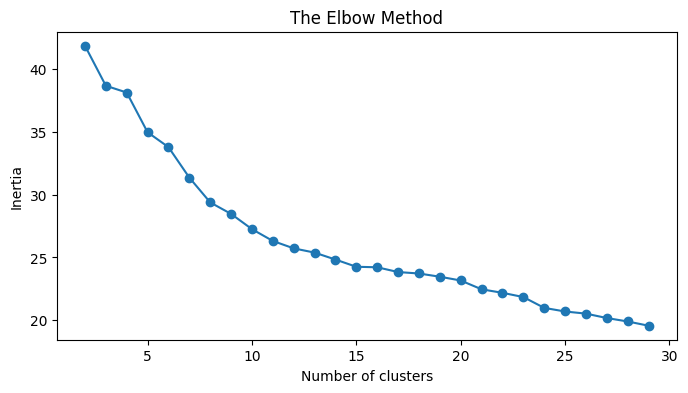

In [138]:
# Applying KMeans clustering on cleaned data with range of clusters
inertia = []

# Initialize lists to store silhouette scores
silhouette_scores = []
range_n_clusters = list(range(8, 21))
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(vectors, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(8, 4))
plt.plot(range(2, 30), inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


TypeError: text() missing 1 required positional argument: 's'

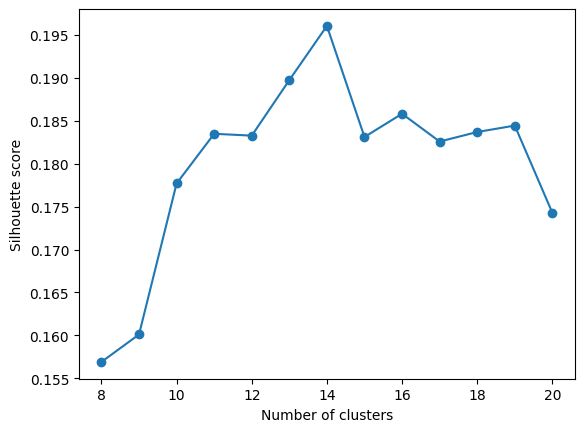

In [139]:
# Plot silhouette scores
silhouette_scores = silhouette_scores[7:20]
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.text(range_n_clusters, silhouette_scores)
plt.title('Silhouette Method for Optimal K')
plt.show()

# From the above graph, we can see that the elbow is at 14. So, we will use 14 clusters for our KMeans clustering

In [140]:
# Applying KMeans clustering on cleaned data with 8 clusters
k_optimal = 15
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=0).fit(vectors)
kmeans_optimal.labels_

array([13,  6,  9,  9,  0, 14, 11,  4,  7, 10, 11,  4,  2,  9, 11,  2,  7,
        5,  4, 10,  8,  7, 12,  9,  8,  9, 13,  4,  5,  7,  8, 11,  5,  1,
       14,  5,  9,  9,  3,  9,  8,  9,  8,  1,  2,  5,  3, 13,  6,  7,  5,
        6, 13,  9,  2,  7,  3,  5,  5, 13,  8,  5,  8,  4,  8, 13, 14, 10,
        3,  0,  4,  3,  3,  2,  6,  0,  5,  5,  9,  2,  4,  8,  0,  0,  8,
       11,  2, 13,  9,  2,  9,  2,  3,  9,  2,  2,  9, 12,  0,  9, 14,  4,
        4,  4,  9, 14,  9,  5,  8,  0, 13,  2,  8, 14, 13,  9,  0,  1,  6,
        7,  8,  9,  2,  9, 13,  8, 14,  9,  9, 13,  2,  0,  4,  2, 14,  6,
       10,  8,  9, 11, 13, 11,  3,  0,  4,  4,  3, 13, 10,  3,  9, 14,  5,
        0, 10, 10,  3,  3,  8,  3,  9, 13,  4,  7,  2, 14,  7,  9,  9,  8,
        6, 10, 10, 14,  9,  5,  0,  9,  9,  2, 10,  7,  9,  2, 10,  5,  0,
       13, 11,  4, 14,  9, 13, 10,  0,  4,  2, 14,  0,  7, 12,  1,  2,  4,
        5,  3, 13,  7,  9,  5,  2,  4,  7,  2,  3, 11,  2,  4,  5,  9,  8,
        9,  9,  9,  9,  9

# Processing the data

In [141]:
import pandas as pd
import os

df = pd.DataFrame(os.path.basename(row['source'])[:-15] for row in data_full_text)
df['label']=kmeans_optimal.labels_
df

,0,label
0,dcc4a106ec167c5624a2b25430f042fd,13
1,e0abc9a25ac589aedafbbb26ec5ece3d,6
2,25a7a30c448e90fe7a74a8cf63d9c974,9
3,e2620553c53f7636ed76c4f45d9a679c,9
4,57ab20f06d415a76b461cc120006cd2d,0
...,...,...
275,ec21736a67a68366ac663509359b7c5a,4
276,1babf4d02b82740ef69faf94d3519029,0
277,bc1dcfe1372f4f0f7692c7108cc9eff5,2
278,879fc26b7fc361fff6bc7681ba235ad3,9


In [142]:
new = {
    "clusters": {
        "cluster_0" : "Cluster 0",
        "cluster_1" : "Cluster 1",
        "cluster_2" : "Cluster 2",
        "cluster_3" : "Cluster 3",
        "cluster_4" : "Cluster 4",
        "cluster_5" : "Cluster 5",
        "cluster_6" : "Cluster 6",
        "cluster_7" : "Cluster 7",
        "cluster_8" : "Cluster 8",
        "cluster_9" : "Cluster 9",
        "cluster_10" : "Cluster 10",
        "cluster_11" : "Cluster 11",
        "cluster_12" : "Cluster 12",
        "cluster_13" : "Cluster 13",
        "cluster_14" : "Cluster 14"
    },
    "samples": {}

}

In [143]:
for index, row in df.iterrows():
    new["samples"][row[0]] = "cluster_" + str(row['label'])
new

{'clusters': {'cluster_0': 'Cluster 0',
  'cluster_1': 'Cluster 1',
  'cluster_2': 'Cluster 2',
  'cluster_3': 'Cluster 3',
  'cluster_4': 'Cluster 4',
  'cluster_5': 'Cluster 5',
  'cluster_6': 'Cluster 6',
  'cluster_7': 'Cluster 7',
  'cluster_8': 'Cluster 8',
  'cluster_9': 'Cluster 9',
  'cluster_10': 'Cluster 10',
  'cluster_11': 'Cluster 11',
  'cluster_12': 'Cluster 12',
  'cluster_13': 'Cluster 13',
  'cluster_14': 'Cluster 14'},
 'samples': {'dcc4a106ec167c5624a2b25430f042fd': 'cluster_13',
  'e0abc9a25ac589aedafbbb26ec5ece3d': 'cluster_6',
  '25a7a30c448e90fe7a74a8cf63d9c974': 'cluster_9',
  'e2620553c53f7636ed76c4f45d9a679c': 'cluster_9',
  '57ab20f06d415a76b461cc120006cd2d': 'cluster_0',
  '44c71bf12711a784d99a2ab2a2968778': 'cluster_14',
  'ef10fc8b264be83ec52bed6a2422d80e': 'cluster_11',
  '59fb71f178f247523719897bb6127a66': 'cluster_4',
  '56f44e496f67769a69bed6500fd7f694': 'cluster_7',
  '412e0942006af3c01d8ea8a9ba481268': 'cluster_10',
  'aa87d3aecf507f0f1e13a00b8b574

In [144]:
import json
file_path = "test_dictionary_data_14.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(new, json_file, indent=4)

print(f"Dictionary saved to {file_path}")

Dictionary saved to test_dictionary_data_14.json


In [9]:
# loader = JSONLoader(
#     file_path='test.json',
#     jq_schema=".ocr[].text",
#     text_content=False)
#
# data = loader.load()
# print(f'document count: {len(data)}')
# data

In [10]:
# # Load the vectorstore
# faiss_index = FAISS.from_documents(data_full_text, embeddings)
# faiss_index.save_local("faiss_index")
# faiss_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [11]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
#
# # Taking out the warnings
# import warnings
# from warnings import simplefilter
#
# # Filter out FutureWarnings
# simplefilter(action='ignore', category=FutureWarning)
#
# # Perform t-SNE and reduce to 2 dimensions
# tsne = TSNE(n_components=2, random_state=42)
# reduced_data_tsne = tsne.fit_transform(vectors)
#
# # Plot the reduced data
# plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title('Book Embeddings Clustered')
# plt.show()